<h2> Load Data</h2>

In [1]:
import warnings
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd
import regex as re
import preparers
import sonaion_analysis as son
import GenSnippetsLib as snippet
import behavioral as bh
import os
import seaborn as sns
import chord
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

<h2>potential funtion arguments</h2>

In [2]:
def get_line_bounds(img, image_path):
    height = img.size[1]
    with open(image_path) as json_file:
        data = json.load(json_file)
        height_margin = data["height-margin"]
        loc = len(data["source-code"])
        height = height - 2 * height_margin

    step_size = height / loc
    bounds = []
    for i in range(loc):
        lower = int(i * step_size) + height_margin
        higher = int((i + 1) * step_size) + height_margin
        bounds.append((i, lower, higher))

    return bounds

In [3]:
fig, ax = (None, None)
denoise_degree = 10
display_width = 1920
display_height = 1080
left_color = (0.0, 1.0, 1.0)
right_color = (0.0, 1.0, 0.0)
image_path = "../CodeSnippets/Generators/" + "BogoSort" + ".json"
img, result = snippet.create_image(image_path, font_path="/../CodeSnippets/fonts/ttf/")
offset = int(display_height * 0.5 - img.size[1] * 0.5)
img_bounds = get_line_bounds(img, image_path)
img_bounds = [(i, low + offset, high + offset) for i, low, high in img_bounds]
loc = len(img_bounds)
line_middle = [int((low + height) / 2) for i, low, height in img_bounds]
bg = snippet.create_background(display_width, display_height, (180, 180, 180, 255))
img = snippet.place_image_on(bg, np.array(img), 0.5, 0.5)
cat = np.full(display_height, None)
for i, low, height in img_bounds:
    for j in range(low, height):
        cat[j] = i

## Get Experience Score Values

In [12]:
df_questionnaire = pd.read_excel("./rawData/Questionnaire.xlsx", sheet_name="Experience")
# transpose the dataframe
df_questionnaire = df_questionnaire.transpose()
# use first row as column names
df_questionnaire.columns = df_questionnaire.iloc[0]
#delete first row
df_questionnaire = df_questionnaire.drop(df_questionnaire.index[0])
#drop row where years of programming is missing
df_questionnaire = df_questionnaire.dropna(subset=["yearsAtWork"])
#change all NaN to 0
df_questionnaire = df_questionnaire.fillna(0)

# drop row with "Participant" beeing 9
df_questionnaire = df_questionnaire.drop(9)

df_questionnaire["yearsOfProgramming"] = df_questionnaire["yearsOfProgramming"].astype(float)
df_questionnaire["yearsOfJava"] = df_questionnaire["yearsOfJava"].astype(float)

In [13]:
# calulate the pearson correlation between the years of programming and the years of java
corr = df_questionnaire.corr(method="pearson")
corr.values[[np.arange(corr.shape[0])] * 2] = 0
corr

<ipython-input-13-b178461af081>:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  corr.values[[np.arange(corr.shape[0])]*2] = 0


Participant,yearsOfProgramming,yearsOfProfessionalProgramming,yearsOfJava,logicalExperience,functionalExperience,imperativExperience,objectExperience,comparedToStudent,comparedToProfessional
Participant,,,,,,,,,
yearsOfProgramming,0.000000,0.912879,0.834671,0.196881,0.277054,0.298009,0.405389,-0.155277,0.222305
yearsOfProfessionalProgramming,0.912879,0.000000,0.755738,0.162842,0.153438,0.211286,0.451542,-0.067585,0.287723
yearsOfJava,0.834671,0.755738,0.000000,0.107167,0.313488,0.186688,0.348047,-0.123541,0.267995
logicalExperience,0.196881,0.162842,0.107167,0.000000,0.438185,0.364237,0.112319,0.161150,0.299794
functionalExperience,0.277054,0.153438,0.313488,0.438185,0.000000,0.311776,0.099272,0.019113,0.308248
imperativExperience,0.298009,0.211286,0.186688,0.364237,0.311776,0.000000,0.393788,-0.083585,0.211158
objectExperience,0.405389,0.451542,0.348047,0.112319,0.099272,0.393788,0.000000,0.078476,0.393626
comparedToStudent,-0.155277,-0.067585,-0.123541,0.161150,0.019113,-0.083585,0.078476,0.000000,0.496090
comparedToProfessional,0.222305,0.287723,0.267995,0.299794,0.308248,0.211158,0.393626,0.496090,0.000000


In [62]:
participants = []
snippets = []
for sub_dirs in list(os.walk("./filteredData"))[0][1]:
    participants.append(int(re.findall(r'\d+', sub_dirs)[0]))

df_behavioral = bh.get_behavioral_df(participants)

In [63]:
#transform the response field, so that "Right" will be "Right" and everything else will be "Wrong"
df_behavioral["Response"] = df_behavioral["Response"].apply(lambda x: "Right" if x == "Right" else "Wrong")
df_behavioral["Duration"] = df_behavioral["Duration"].astype(float)
df_behavioral

,Duration,Response,Snippet
Participant,,,
1,27.286223,Wrong,Ackerman
1,23.420816,Wrong,ArrayAverage
1,49.922091,Right,BinToDecimal
1,47.770645,Wrong,BinarySearch
1,82.632721,Wrong,BinomialCoefficient
...,...,...,...
71,35.637456,Right,SiebDesEratosthenes
71,16.485685,Right,SignChecker
71,18.607310,Right,SmallGauss


In [68]:
lowest = df_behavioral["Duration"].quantile(0.05)
highest = df_behavioral["Duration"].quantile(0.95)
# kick out all rows where the duration is not in the 5% quantile range
df_behavioral = df_behavioral[
    ((df_behavioral["Duration"] > lowest) & (df_behavioral["Duration"] < highest))
    | (df_behavioral["Duration"] <= lowest) & (df_behavioral["Response"] == "Right")]


(0.0, 33.0)

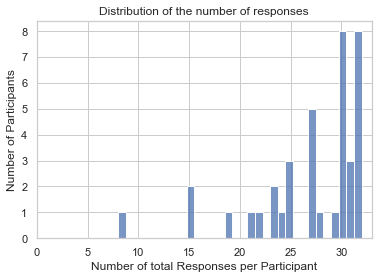

In [83]:
df_tmp = df_behavioral.groupby("Participant").count()
# create a histogram of the duration of the snippets
g = sns.histplot(df_tmp["Duration"],bins=32,label="Participants")
g.set_xlabel("Number of total Responses per Participant")
g.set_ylabel("Number of Participants")
g.set_title("Distribution of the number of responses")
g.set_xlim(0, 33)

In [84]:
# get the total time of the experiment per participant
participants = []
for sub_dirs in list(os.walk("./rawData"))[0][1]:
    participants.append(int(re.findall(r'\d+', sub_dirs)[0]))

df_times = pd.DataFrame(columns=["Participant", "totalTime"])
for participant in participants:
    participant_folder = "./rawData/Participant{}/".format(str(participant).zfill(2))
    psychopy_csv_path = participant_folder

    # get path for psychopy log and csv data
    for (dirpath, dirnames, filenames) in os.walk(psychopy_csv_path):
        for file in filenames:
            file, ext = os.path.splitext(file)
            if ext == ".csv" and "test" in file:
                psychopy_csv_path += file + ext

    # read csv file
    df = pd.read_csv(psychopy_csv_path)
    end_time = df.iloc[-2]["continuQuestion.started"]

    # drop where ImagePath is empty
    df = df.dropna(subset=["ImagePath"])

    # get the Image.started from the first row
    start_time = df.iloc[0]["Image.started"]
    # calculate the total time
    total_time = end_time - start_time
    # add the participant and total time to the dataframe
    df_times = df_times.append({"Participant": int(participant), "totalTime": total_time}, ignore_index=True)

# set index to participant
df_times["Participant"] = df_times["Participant"].astype(int)
df_times = df_times.set_index("Participant", drop=True)
df_behavioral["totalTime"] = df_times["totalTime"]

In [85]:
df_behavioral

,Duration,Response,Snippet,totalTime
Participant,,,,
1,27.286223,Wrong,Ackerman,4058.363428
1,23.420816,Wrong,ArrayAverage,4058.363428
1,49.922091,Right,BinToDecimal,4058.363428
1,47.770645,Wrong,BinarySearch,4058.363428
1,82.632721,Wrong,BinomialCoefficient,4058.363428
...,...,...,...,...
71,35.637456,Right,SiebDesEratosthenes,3518.707351
71,16.485685,Right,SignChecker,3518.707351
71,18.607310,Right,SmallGauss,3518.707351


In [86]:
df_tmp = df_behavioral.copy()
df_tmp.reset_index(inplace=True)
df_tmp

,Participant,Duration,Response,Snippet,totalTime
0,1,27.286223,Wrong,Ackerman,4058.363428
1,1,23.420816,Wrong,ArrayAverage,4058.363428
2,1,49.922091,Right,BinToDecimal,4058.363428
3,1,47.770645,Wrong,BinarySearch,4058.363428
4,1,82.632721,Wrong,BinomialCoefficient,4058.363428
...,...,...,...,...,...
1021,71,35.637456,Right,SiebDesEratosthenes,3518.707351
1022,71,16.485685,Right,SignChecker,3518.707351
1023,71,18.607310,Right,SmallGauss,3518.707351
1024,71,6.636784,Right,SumArray,3518.707351


In [100]:
# create a dataframe counting the correct answers and the total time per participant based on the dataframe df_behavioral
df_correct = pd.DataFrame(columns=["Participant", "correct", "total", "totalTime"])

for participant in participants:
    correct = len(df_tmp[(df_tmp["Participant"] == participant) & (df_tmp["Response"] == "Right")])
    total = len(df_tmp[df_tmp["Participant"] == participant])
    total_time = df_tmp[df_tmp["Participant"] == participant]["totalTime"].iloc[0]
    df_correct = df_correct.append(
        {"Participant": participant, "correct": correct, "total": total, "totalTime": total_time}, ignore_index=True)

df_correct["correct_per_minute"] = df_correct["correct"] / (df_correct["totalTime"] / (60.0))
df_correct["correct_per_minute"] = df_correct["correct_per_minute"].astype(float)
df_correct

,Participant,correct,total,totalTime,correct_per_minute
0,1.0,22.0,32.0,4058.363428,0.325254
1,2.0,26.0,32.0,4187.046853,0.372578
2,3.0,13.0,15.0,2535.913164,0.307582
3,4.0,28.0,32.0,4035.150472,0.416341
4,5.0,20.0,32.0,3909.367293,0.306955
5,6.0,21.0,28.0,3889.560329,0.323944
6,7.0,28.0,31.0,4068.585990,0.412920
7,10.0,20.0,30.0,3497.319535,0.343120
8,11.0,12.0,19.0,4070.275834,0.176892
9,12.0,21.0,27.0,4041.637541,0.311755


In [101]:
df_correct["correct_per_minute"].describe()

count    38.000000
mean      0.317823
std       0.104168
min       0.086166
25%       0.246571
50%       0.317538
75%       0.369982
max       0.638280
Name: correct_per_minute, dtype: float64

Text(0.5, 1.0, 'Correct answers per minute Distribution')

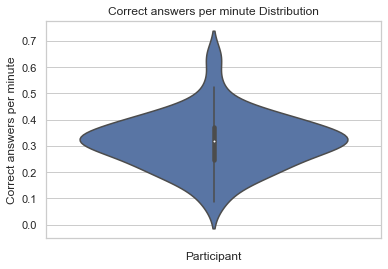

In [102]:
#plot the correct answers per minute as violin plot
g = sns.violinplot(y="correct_per_minute", data=df_correct, inner="box")
g.set_xlabel("Participant")
g.set_ylabel("Correct answers per minute")
g.set_title("Correct answers per minute Distribution")

In [103]:
# check if correct_per_time is normal distributed with shapiro-wilk test
import scipy

scipy.stats.shapiro(df_correct["correct_per_minute"])

ShapiroResult(statistic=0.9681628942489624, pvalue=0.34470608830451965)

In [104]:
df_correct["Participant"] = df_correct["Participant"].astype(int)
df_correct = df_correct.set_index("Participant", drop=True)
df_correct

,correct,total,totalTime,correct_per_minute
Participant,,,,
1,22.0,32.0,4058.363428,0.325254
2,26.0,32.0,4187.046853,0.372578
3,13.0,15.0,2535.913164,0.307582
4,28.0,32.0,4035.150472,0.416341
5,20.0,32.0,3909.367293,0.306955
6,21.0,28.0,3889.560329,0.323944
7,28.0,31.0,4068.585990,0.412920
10,20.0,30.0,3497.319535,0.343120
11,12.0,19.0,4070.275834,0.176892


In [108]:
# merge the dataframes df_behavioral and df_correct
df_tmp = pd.merge(df_behavioral, df_correct, on="Participant")
df_tmp = df_tmp.drop(columns=["totalTime_x"])
# rename the column totalTime_y to totalTime
df_behavioral = df_tmp.rename(columns={"totalTime_y": "totalTime"})
df_behavioral

,Duration,Response,Snippet,correct,total,totalTime,correct_per_minute
Participant,,,,,,,
1,27.286223,Wrong,Ackerman,22.0,32.0,4058.363428,0.325254
1,23.420816,Wrong,ArrayAverage,22.0,32.0,4058.363428,0.325254
1,49.922091,Right,BinToDecimal,22.0,32.0,4058.363428,0.325254
1,47.770645,Wrong,BinarySearch,22.0,32.0,4058.363428,0.325254
1,82.632721,Wrong,BinomialCoefficient,22.0,32.0,4058.363428,0.325254
...,...,...,...,...,...,...,...
71,35.637456,Right,SiebDesEratosthenes,25.0,31.0,3518.707351,0.426293
71,16.485685,Right,SignChecker,25.0,31.0,3518.707351,0.426293
71,18.607310,Right,SmallGauss,25.0,31.0,3518.707351,0.426293


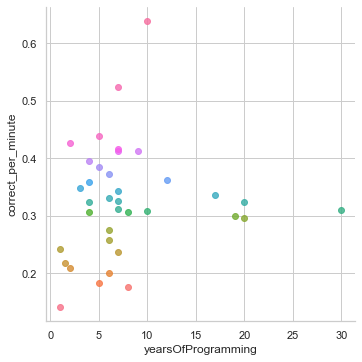

In [127]:
df_questionnaire["correct_per_minute"] = df_behavioral["correct_per_minute"].drop_duplicates()
# do a scatterplot based on yearsOfProgramming and correct_per_minute
sns.set(style="whitegrid")
g = sns.lmplot(x="yearsOfProgramming", y="correct_per_minute", data=df_questionnaire, hue="correct_per_minute", legend=False)

<h2> Prepare queried Data</h2>

In [130]:
def update_names(df_eyetracking, name_dict):
    df_eyetracking = df_eyetracking.rename(columns=name_dict)
    return df_eyetracking

In [131]:
def update_to_display_coordinates(df_eyetracking):
    df_eyetracking["display_x"] = df_eyetracking["display_x"].apply(lambda x: x * display_width)
    df_eyetracking["display_x"] = df_eyetracking["display_x"].astype(float).fillna(0).astype(int)

    df_eyetracking["display_y"] = df_eyetracking["display_y"].apply(lambda x: x * display_height)
    df_eyetracking["display_y"] = df_eyetracking["display_y"].astype(float).fillna(0).astype(int)
    return df_eyetracking

In [132]:
def update_normalize_time(df_eyetracking):
    df_eyetracking["time"] = df_eyetracking["time"] - df_eyetracking["time"][0]
    return df_eyetracking

In [133]:
def update_replace_invalid(df_eyetracking):
    (
        replaced_x,
        replaced_y,
        replaced_diameter,
        replaced_valid,
    ) = son.eyetracking.preprocessing_invalid.replace_with_prev_invalid(
        df_eyetracking["display_x"],
        df_eyetracking["display_y"],
        df_eyetracking["pupil_diameter"],
        df_eyetracking["valid"],
    )

    df_eyetracking["display_x"] = replaced_x
    df_eyetracking["display_y"] = replaced_y
    df_eyetracking["pupil_diameter"] = replaced_diameter
    df_eyetracking["valid"] = replaced_valid
    return df_eyetracking

In [134]:
def update_denoise(df_eyetracking, denoise_degree):
    for _i in range(denoise_degree):
        denoised_x, denoised_y = son.eyetracking.preprocessing_denoise.denoise(
            df_eyetracking["display_x"],
            df_eyetracking["display_y"],
            son.eyetracking.preprocessing_denoise.parabola_5_kernel,
        )

        df_eyetracking["display_x"] = denoised_x
        df_eyetracking["display_y"] = denoised_y
    return df_eyetracking

In [135]:
def update_match_to_line(df_eyetracking, line_middle, cat):
    df_eyetracking["display_y"] = df_eyetracking["display_y"].apply(
        lambda x: line_middle[cat[x]] if cat[x] is not None else float("Nan"))
    df_eyetracking = df_eyetracking[df_eyetracking["display_y"].notnull()]
    df_eyetracking["display_y"] = df_eyetracking["display_y"].astype(int)
    df_eyetracking = df_eyetracking.reset_index()
    return df_eyetracking

In [136]:
def mask_function():
    return lambda height, width, coordinate: son.utils.masks.create_circular_mask(height, width, coordinate, 30)


def create_heatmap(df_eyetracking, color, width, height):
    heat_data = son.eyetracking.heatmap.create_heatmap(
        df_eyetracking["display_x"],
        df_eyetracking["display_y"],
        df_eyetracking["valid"],
        0.004,
        width,
        height,
        mask_function(),
    )

    heat_data = heat_data / heat_data.max()
    heat_data = np.array([heat_data * color[0], heat_data * color[1], heat_data * color[2], heat_data])
    heat_data = np.moveaxis(heat_data, 0, 2)
    return heat_data

In [137]:
def create_sequence_diagram(df_eyetracking, color, width, height, max_pixel):
    step_size = max_pixel / len(df_eyetracking)

    sequence_data = son.eyetracking.sequence.create_sequence_diagram_y(
        df_eyetracking["display_y"],
        df_eyetracking["valid"],
        height,
        width,
        offset=0,
        step=step_size,
        should_skip=False,
    )
    sequence_data = np.array(
        [sequence_data * color[0], sequence_data * color[1], sequence_data * color[2], sequence_data])
    sequence_data = np.moveaxis(sequence_data, 0, 2)
    return sequence_data

In [138]:
def get_fixation_saccades_metrics(df_eyetracking, d_time):
    d_time = 0.004
    threshold_for_fixation = 2400.0
    saccades = son.eyetracking.metrics.classify_saccades(df_eyetracking["display_x"], df_eyetracking["display_y"],
                                                         d_time, threshold_for_fixation)
    if len(saccades) >= 1:
        saccades[0] = saccades[1]

    fixxation = son.eyetracking.metrics.classify_fixxation(df_eyetracking["display_x"], df_eyetracking["display_y"],
                                                           d_time, threshold_for_fixation)
    if len(fixxation) >= 1:
        fixxation[0] = fixxation[1]

    saccades = np.array(saccades)
    fixxation = np.array(fixxation)

    saccades_count = son.eyetracking.metrics.count_saccades(saccades)
    if saccades_count == 0:
        saccades_time_of_first = 0
        saccades_average_time = 0
    else:
        saccades_time_of_first = son.eyetracking.metrics.time_of_saccades(saccades, d_time)[0][0]
        saccades_average_time = son.eyetracking.metrics.average_saccades_time(
            son.eyetracking.metrics.time_of_saccades(saccades, d_time))

    fixxation_count = son.eyetracking.metrics.count_fixxations(fixxation)
    if fixxation_count == 0:
        fixxation_time_of_first = 0
        fixxation_average_time = 0
    else:
        fixxation_time_of_first = son.eyetracking.metrics.time_of_fixxations(fixxation, d_time)[0][0]
        fixxation_average_time = son.eyetracking.metrics.average_fixxations_time(
            son.eyetracking.metrics.time_of_fixxations(fixxation, d_time))

    return pd.DataFrame([[
        saccades_count,
        saccades_time_of_first,
        saccades_average_time,
        fixxation_count,
        fixxation_time_of_first,
        fixxation_average_time,
    ]], columns=["Saccades Count", "Time to first Saccade", "Average Saccade Time", "Fixation Count",
                 "Time to first Fixation", "Average Fixation Time"])

In [47]:
df_eyetracking = data["BogoSort"]["Code"]["EyeTracking"][
    [
        "l_valid",
        "l_display_x",
        "l_display_y",
        "time",
        "l_pupil_diameter",
    ]
]

left_naming = {
    "l_valid": "valid",
    "l_display_x": "display_x",
    "l_display_y": "display_y",
    "l_pupil_diameter": "pupil_diameter",
}

right_naming = {
    "r_valid": "valid",
    "r_display_x": "display_x",
    "r_display_y": "display_y",
    "r_pupil_diameter": "pupil_diameter",
}

df_eyetracking = update_names(df_eyetracking, left_naming)
df_eyetracking = update_to_display_coordinates(df_eyetracking)
df_eyetracking = update_normalize_time(df_eyetracking)
df_eyetracking = update_replace_invalid(df_eyetracking)
df_eyetracking = update_denoise(df_eyetracking, denoise_degree)
df_eyetracking = update_match_to_line(df_eyetracking, line_middle, cat)